In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

n, r = 100, 10

# We start by making a random symmetric matrix A

rng         = np.random.default_rng(123)
U_A, _      = scipy.linalg.qr(rng.standard_normal((n, r)), mode='economic')

sing_vals_A = np.logspace(-7, 2, r)[::-1]

A = U_A @ np.diag(sing_vals_A) @ U_A.T

# Define the angle of rotation

thetas = np.linspace(0, 1e-01, 50) # needs to be small for our epsilon-theta relation

LHS_bound = []
RHS_bound = []

for i, theta in enumerate(thetas):
    # z \perpto span(U_A), unit-norm
    z = rng.standard_normal((n, 1))
    z -= U_A @ (U_A.T @ z)
    z /= np.linalg.norm(z)

    V_A = U_A.copy()
    c, s = np.cos(theta), np.sin(theta)

    # rotate column -1 toward z
    v0_rot = c * U_A[:, [-1]] + s * z
    V_A[:, [-1]] = v0_rot

    # re-orthonormalise the r columns
    V_A, _ = scipy.linalg.qr(V_A, mode="economic")

    sigma_min_2 = scipy.linalg.svd(U_A.T @ V_A, compute_uv=False)[-1]

    A = U_A @ np.diag(sing_vals_A) @ V_A.T

    epsilon = A - A.T

    A_s = 0.5 * (A + A.T)

    X = np.random.randn(n,r)

    AsX = A_s @ X

    A_s_nyst = (AsX) @ scipy.linalg.pinv(X.T @ AsX) @ (AsX).T

    AX = A @ X

    A_nyst = AX @ scipy.linalg.pinv(X.T @ AX) @ (AX).T

    LHS_bound_A_A_nyst = np.linalg.norm(A - A_nyst)

    LHS_bound.append(LHS_bound_A_A_nyst)

    RHS_bound_A_s_nyst = np.linalg.nprm(A_s - A_s_nyst)

    epsilon_bound = np.linalg.norm(epsilon)

    RHS_together = RHS_bound_A_s_nyst + epsilon_bound

    RHS_bound.append(RHS_together)

Computing Nyström approximations...
Progress: 0/50
Progress: 10/50
Progress: 20/50
Progress: 30/50
Progress: 40/50
Creating plots...


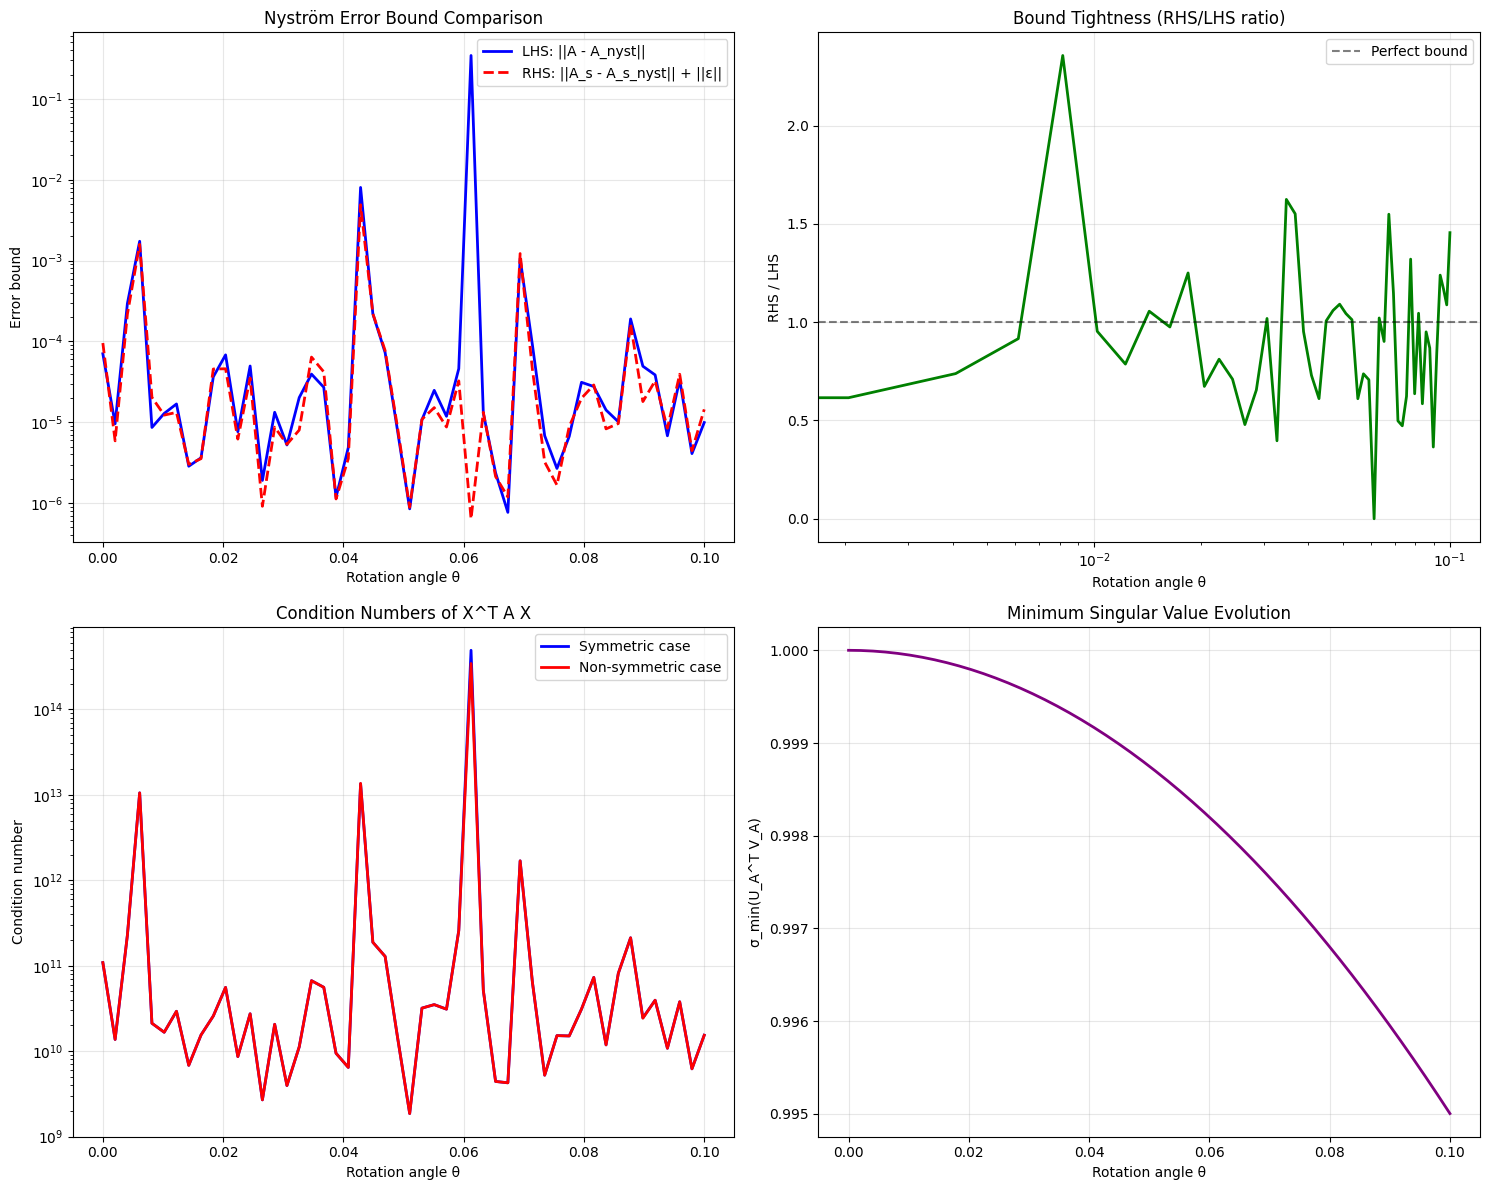


ANALYSIS SUMMARY
Number of theta values: 50
Theta range: [0.000000, 0.100000]

LHS Error Statistics:
  Min: 7.69e-07
  Max: 3.45e-01
  Mean: 7.14e-03

RHS Bound Statistics:
  Min: 6.41e-07
  Max: 4.91e-03
  Mean: 1.83e-04

Bound Ratio Statistics:
  Min: 0.00
  Max: 2.36
  Mean: 0.93

Condition Number Statistics:
  Symmetric - Mean: 1.04e+13
  Non-symmetric - Mean: 7.47e+12

Numerical Stability:
  ⚠ Symmetric case: Potentially unstable
  ⚠ Non-symmetric case: Potentially unstable


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.linalg import qr, svd, solve

def nystrom_stable(A, X):
    """More numerically stable Nyström approximation using QR decomposition"""
    AX = A @ X
    XTAX = X.T @ AX  # More stable than X.T @ A @ X
    
    # Use QR decomposition for better numerical stability
    Q, R = qr(XTAX)
    
    # Check if R is well-conditioned
    cond_R = np.linalg.cond(R)
    
    if cond_R < 1e12:  # Use QR-based solve
        temp = solve(R, Q.T)
        return AX @ temp @ AX.T, cond_R
    else:  # Fall back to SVD-based pseudoinverse
        U, s, Vt = svd(XTAX, full_matrices=False)
        threshold = np.finfo(float).eps * max(XTAX.shape) * s[0]
        s_inv = np.where(s > threshold, 1.0/s, 0.0)
        XTAX_pinv = Vt.T @ np.diag(s_inv) @ U.T
        return AX @ XTAX_pinv @ AX.T, cond_R

n, r = 100, 10

# We start by making a random symmetric matrix A
rng = np.random.default_rng(123)
U_A, _ = scipy.linalg.qr(rng.standard_normal((n, r)), mode='economic')

sing_vals_A = np.logspace(-7, 2, r)[::-1]

A = U_A @ np.diag(sing_vals_A) @ U_A.T

# Define the angle of rotation
thetas = np.linspace(0, 1e-01, 50)  # needs to be small for our epsilon-theta relation

LHS_bound = []
RHS_bound = []
condition_numbers = []
sigma_min_values = []

print("Computing Nyström approximations...")

for i, theta in enumerate(thetas):
    if i % 10 == 0:
        print(f"Progress: {i}/{len(thetas)}")
    
    # z ⊥ span(U_A), unit-norm
    z = rng.standard_normal((n, 1))
    z -= U_A @ (U_A.T @ z)
    z /= np.linalg.norm(z)

    V_A = U_A.copy()
    c, s = np.cos(theta), np.sin(theta)

    # rotate column -1 toward z
    v0_rot = c * U_A[:, [-1]] + s * z
    V_A[:, [-1]] = v0_rot

    # re-orthonormalise the r columns
    V_A, _ = scipy.linalg.qr(V_A, mode="economic")

    sigma_min_2 = scipy.linalg.svd(U_A.T @ V_A, compute_uv=False)[-1]
    sigma_min_values.append(sigma_min_2)

    A = U_A @ np.diag(sing_vals_A) @ V_A.T

    epsilon = A - A.T

    A_s = 0.5 * (A + A.T)

    X = rng.standard_normal((n, r))  # Use the same rng for reproducibility

    # Symmetric part approximation (more stable method)
    AsX = A_s @ X
    A_s_nyst, cond_s = nystrom_stable(A_s, X)

    # Non-symmetric approximation (more stable method)
    AX = A @ X
    A_nyst, cond_nonsym = nystrom_stable(A, X)
    
    condition_numbers.append((cond_s, cond_nonsym))

    # LHS: ||A - A_nyst||
    LHS_bound_A_A_nyst = np.linalg.norm(A - A_nyst)
    LHS_bound.append(LHS_bound_A_A_nyst)

    # RHS: ||A_s - A_s_nyst|| + ||epsilon||
    RHS_bound_A_s_nyst = np.linalg.norm(A_s - A_s_nyst)  # Fixed typo here
    epsilon_bound = np.linalg.norm(epsilon)
    RHS_together = RHS_bound_A_s_nyst + epsilon_bound
    RHS_bound.append(RHS_together)

print("Creating plots...")

# Create comprehensive plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Main bound comparison
ax1.semilogy(thetas, LHS_bound, 'b-', label='LHS: ||A - A_nyst||', linewidth=2)
ax1.semilogy(thetas, RHS_bound, 'r--', label='RHS: ||A_s - A_s_nyst|| + ||ε||', linewidth=2)
ax1.set_xlabel('Rotation angle θ')
ax1.set_ylabel('Error bound')
ax1.set_title('Nyström Error Bound Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Bound ratio
bound_ratios = np.array(RHS_bound) / np.array(LHS_bound)
ax2.semilogx(thetas, bound_ratios, 'g-', linewidth=2)
ax2.set_xlabel('Rotation angle θ')
ax2.set_ylabel('RHS / LHS')
ax2.set_title('Bound Tightness (RHS/LHS ratio)')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Perfect bound')
ax2.legend()

# Plot 3: Condition numbers
cond_s = [c[0] for c in condition_numbers]
cond_nonsym = [c[1] for c in condition_numbers]
ax3.semilogy(thetas, cond_s, 'b-', label='Symmetric case', linewidth=2)
ax3.semilogy(thetas, cond_nonsym, 'r-', label='Non-symmetric case', linewidth=2)
ax3.set_xlabel('Rotation angle θ')
ax3.set_ylabel('Condition number')
ax3.set_title('Condition Numbers of X^T A X')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Sigma_min evolution
ax4.plot(thetas, sigma_min_values, 'purple', linewidth=2)
ax4.set_xlabel('Rotation angle θ')
ax4.set_ylabel('σ_min(U_A^T V_A)')
ax4.set_title('Minimum Singular Value Evolution')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"Number of theta values: {len(thetas)}")
print(f"Theta range: [{thetas[0]:.6f}, {thetas[-1]:.6f}]")
print(f"\nLHS Error Statistics:")
print(f"  Min: {np.min(LHS_bound):.2e}")
print(f"  Max: {np.max(LHS_bound):.2e}")
print(f"  Mean: {np.mean(LHS_bound):.2e}")
print(f"\nRHS Bound Statistics:")
print(f"  Min: {np.min(RHS_bound):.2e}")
print(f"  Max: {np.max(RHS_bound):.2e}")
print(f"  Mean: {np.mean(RHS_bound):.2e}")
print(f"\nBound Ratio Statistics:")
print(f"  Min: {np.min(bound_ratios):.2f}")
print(f"  Max: {np.max(bound_ratios):.2f}")
print(f"  Mean: {np.mean(bound_ratios):.2f}")
print(f"\nCondition Number Statistics:")
print(f"  Symmetric - Mean: {np.mean(cond_s):.2e}")
print(f"  Non-symmetric - Mean: {np.mean(cond_nonsym):.2e}")
print(f"\nNumerical Stability:")
if np.mean(cond_s) < 1e12:
    print("  ✓ Symmetric case: Numerically stable")
else:
    print("  ⚠ Symmetric case: Potentially unstable")
if np.mean(cond_nonsym) < 1e12:
    print("  ✓ Non-symmetric case: Numerically stable")
else:
    print("  ⚠ Non-symmetric case: Potentially unstable")